# Constraining the inversion

This notebook explains some additional approaches we employ to `smallness regularization`. In this scenario, we aim to invert for the sediment-basement contact with some outcropping basement at the surface. We employ the following constraints:
1) Inverted basement should not cross the surface topography (`upper_confining_layer`)
2) Inverted basement should not go below 100 m elevation ((`lower_confining_layer`))
3) Limit changes to starting model in areas of known basement depth using a `weighting grid`.
4) For outcropping basement locations, exclude prisms from the inversion to reduce computation.
   
Again, we will use the same synthetic data from the past examples.

## Import packages

In [1]:
import numpy as np
import polartoolkit as ptk
import verde as vd
import xarray as xr

import invert4geom

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data

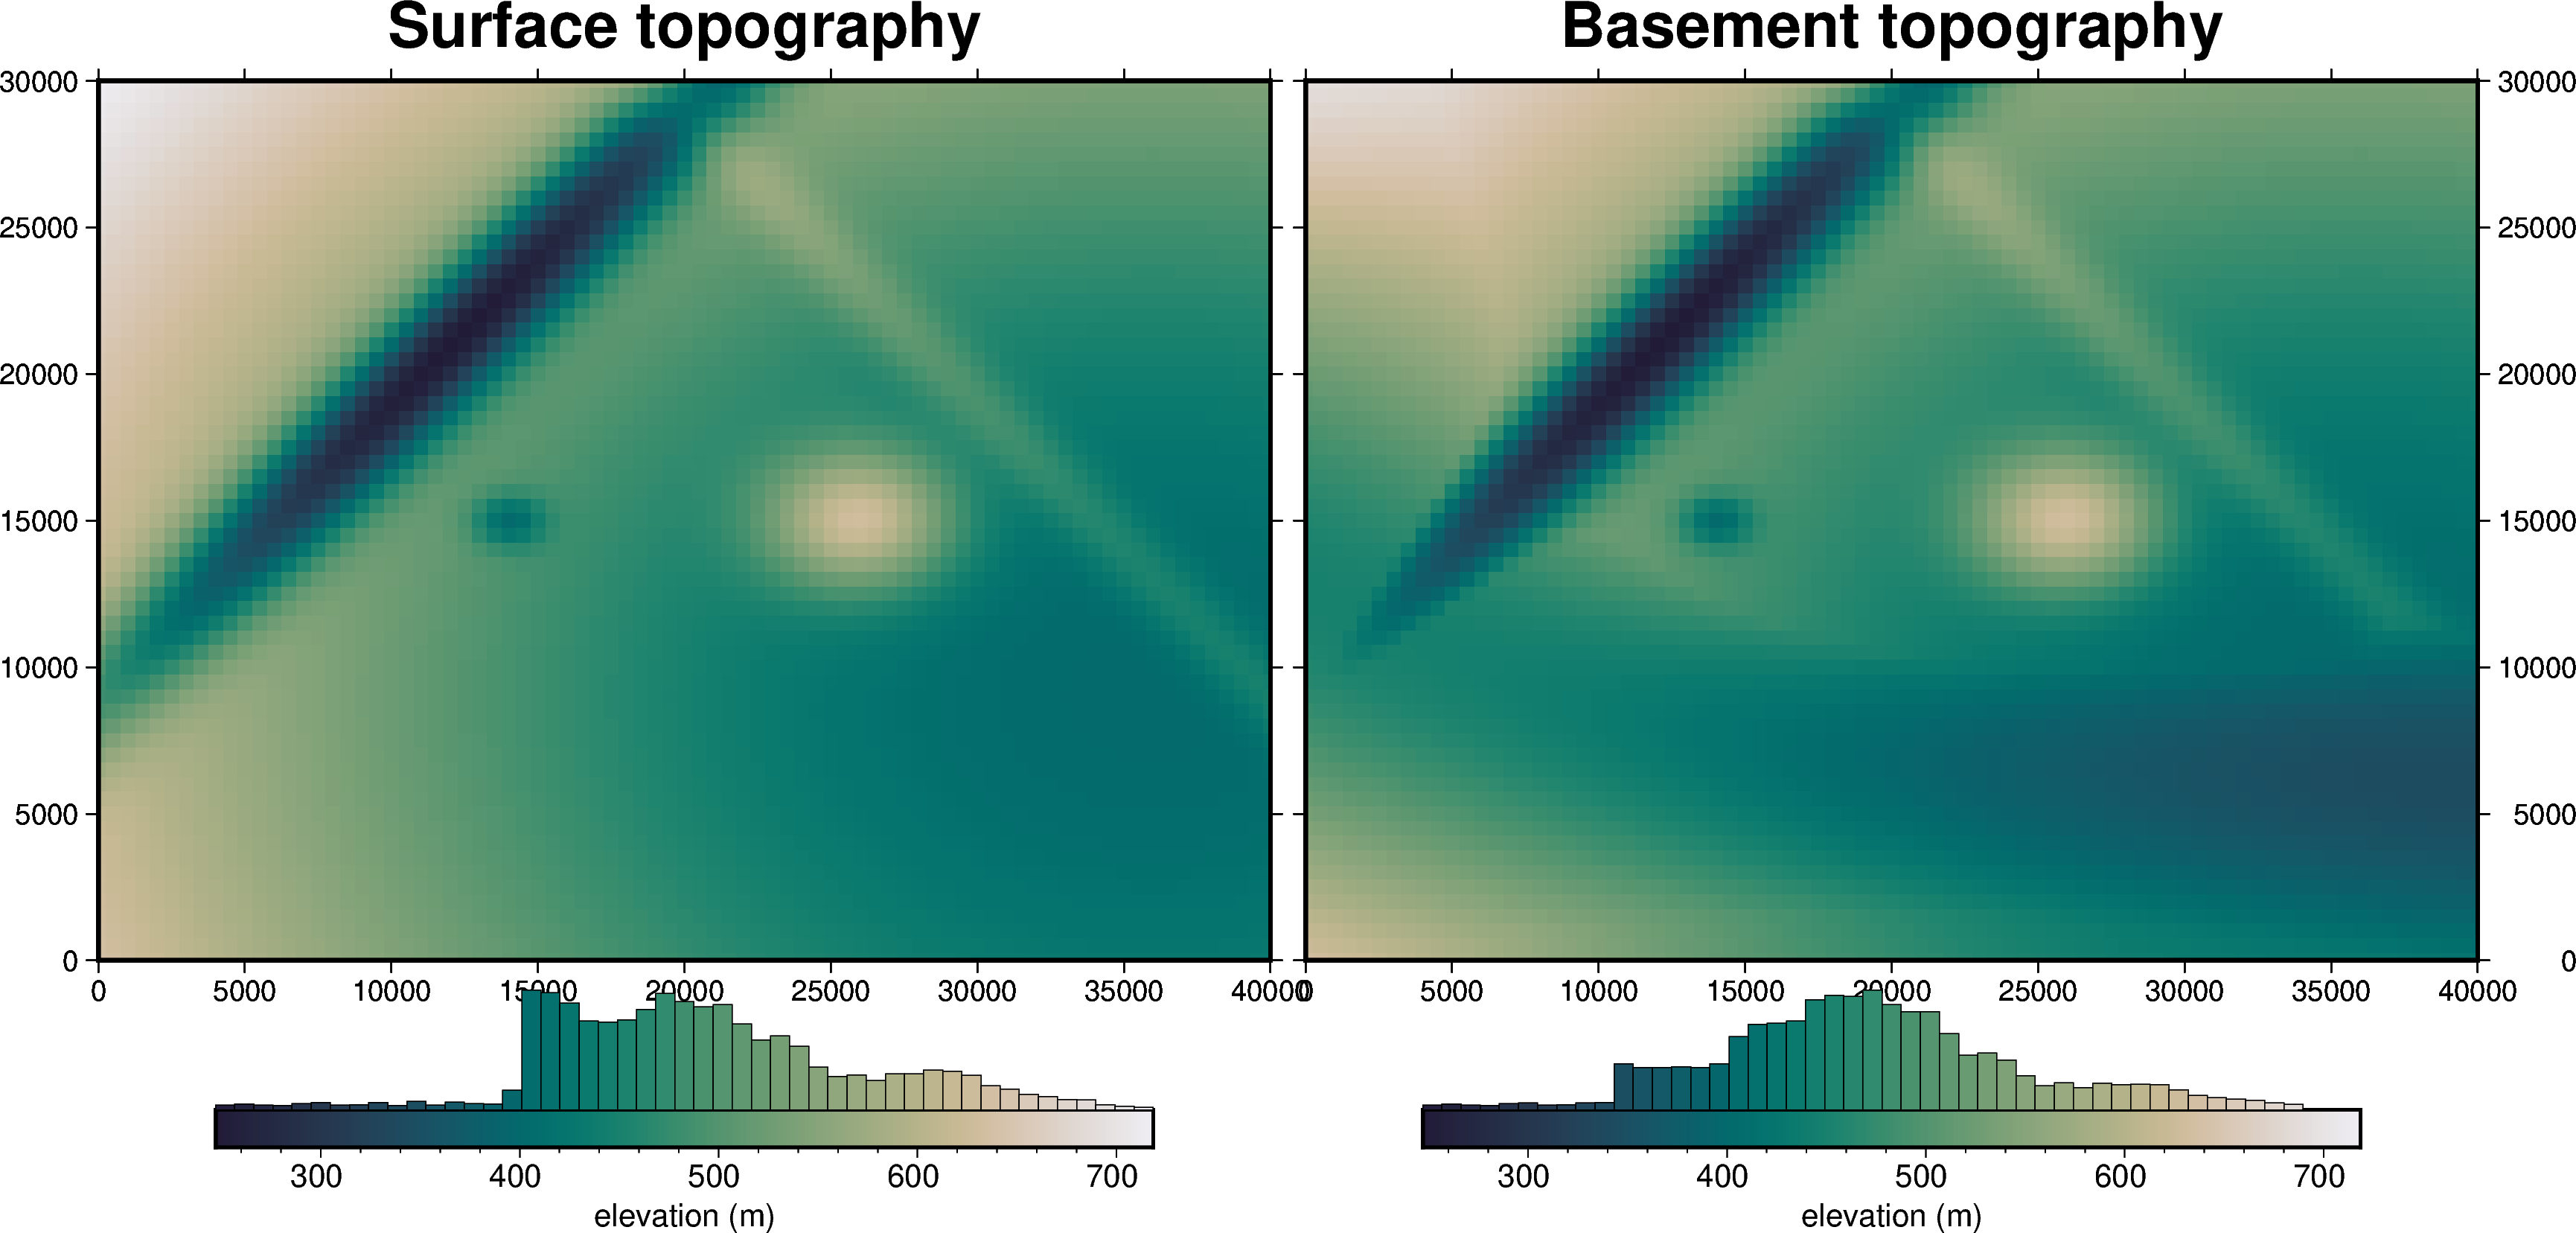

In [2]:
true_surface_topography, _, _, _ = invert4geom.load_synthetic_model(
    spacing=500,
    region=(0, 40000, 0, 30000),
    zref=0,
)

# create lower synthetic topography data
true_basement_topography = invert4geom.synthetic_topography_regional(
    spacing=500,
    region=(0, 40000, 0, 30000),
    scale=3,
    yoffset=600,
)

# clip lower topography to be always below true topography
true_basement_topography = xr.where(
    true_basement_topography < true_surface_topography,
    true_basement_topography,
    true_surface_topography,
)
cpt_lims = ptk.get_combined_min_max([true_surface_topography, true_basement_topography])
fig = ptk.plot_grid(
    true_surface_topography,
    fig_height=10,
    title="Surface topography",
    cmap="rain",
    reverse_cpt=True,
    cpt_lims=cpt_lims,
    hist=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    true_basement_topography,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Basement topography",
    cmap="rain",
    reverse_cpt=True,
    cpt_lims=cpt_lims,
    hist=True,
    cbar_label="elevation (m)",
    frame=["nSwE", "xaf10000", "yaf10000"],
)
fig.show()

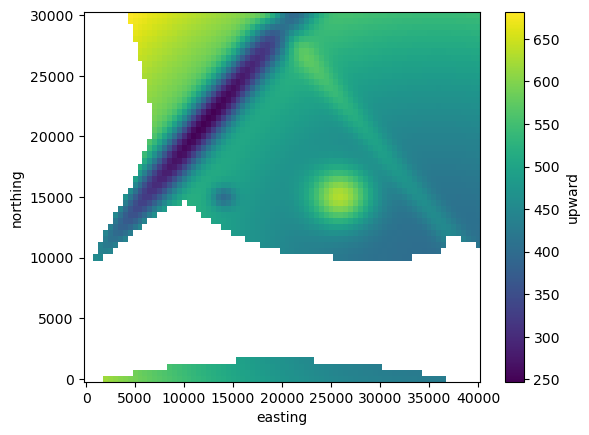

In [3]:
outcropping_basement = true_basement_topography.where(
    true_basement_topography == true_surface_topography,
)
outcropping_basement.plot()

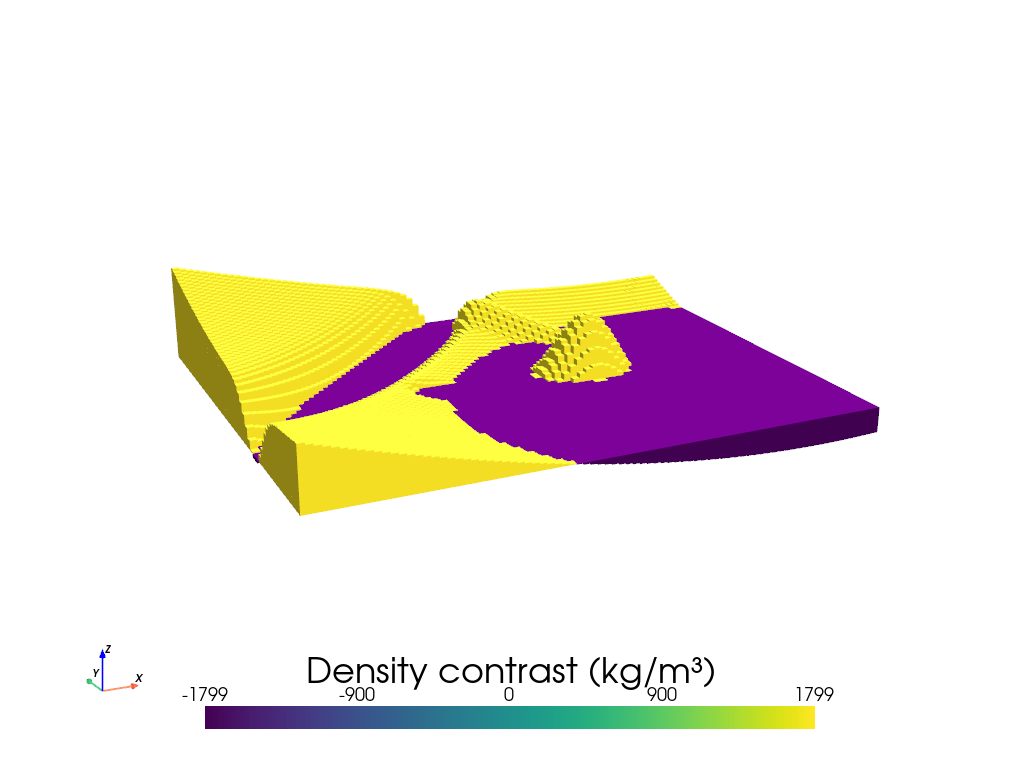

In [4]:
# the first density contrast is between sediment (~1800 kg/m3) and air (~1 kg/m3)
surface_density_contrast = 1800 - 1

surface_model = invert4geom.create_model(
    zref=true_surface_topography.to_numpy().mean(),
    density_contrast=surface_density_contrast,
    topography=true_surface_topography.to_dataset(name="upward"),
)

surface_model.inv.plot_model(
    color_by="density",
    zscale=30,
)

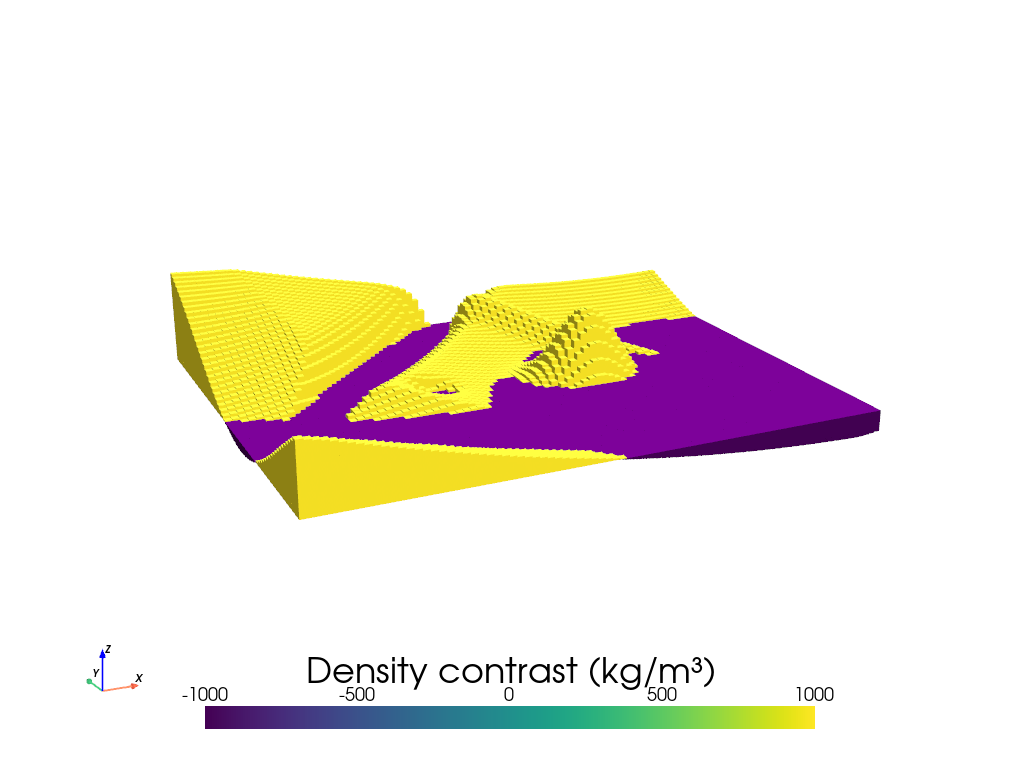

In [5]:
# the second density contrast is between basement (~2800 kg/m3) and sediment (~1800 kg/m3)
basement_density_contrast = 2800 - 1800

basement_model = invert4geom.create_model(
    zref=true_basement_topography.to_numpy().mean(),
    # zref = 0,
    density_contrast=basement_density_contrast,
    topography=true_basement_topography.to_dataset(name="upward"),
)

basement_model.inv.plot_model(
    color_by="density",
    zscale=30,
)

In [6]:
# invert4geom.plot_prism_layers(
#     [surface_model, basement_model],
#     # color_by="constant",
#     color_by="density",
#     zscale=30,
#     constant_colors=["saddlebrown", "blue"],
# )

In [7]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    spacing=500,
    region=(0, 40000, 0, 30000),
    pixel_register=False,
    extra_coords=1001,  # survey elevation
)

observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

# forward gravity of upper and lower prisms
grav_data.inv.forward_gravity(surface_model, "surface_grav")
grav_data.inv.forward_gravity(basement_model, "basement_grav")

grav_data["observed_gravity"] = grav_data.surface_grav + grav_data.basement_grav
grav_data

<xarray.Dataset> Size: 159kB
Dimensions:           (northing: 61, easting: 81)
Coordinates:
  * easting           (easting) float64 648B 0.0 500.0 1e+03 ... 3.95e+04 4e+04
  * northing          (northing) float64 488B 0.0 500.0 1e+03 ... 2.95e+04 3e+04
Data variables:
    upward            (northing, easting) float64 40kB 1.001e+03 ... 1.001e+03
    surface_grav      (northing, easting) float64 40kB 4.695 5.754 ... 1.389
    basement_grav     (northing, easting) float64 40kB 2.747 3.407 ... 1.131
    observed_gravity  (northing, easting) float64 40kB 7.443 9.161 ... 2.519
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       500.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

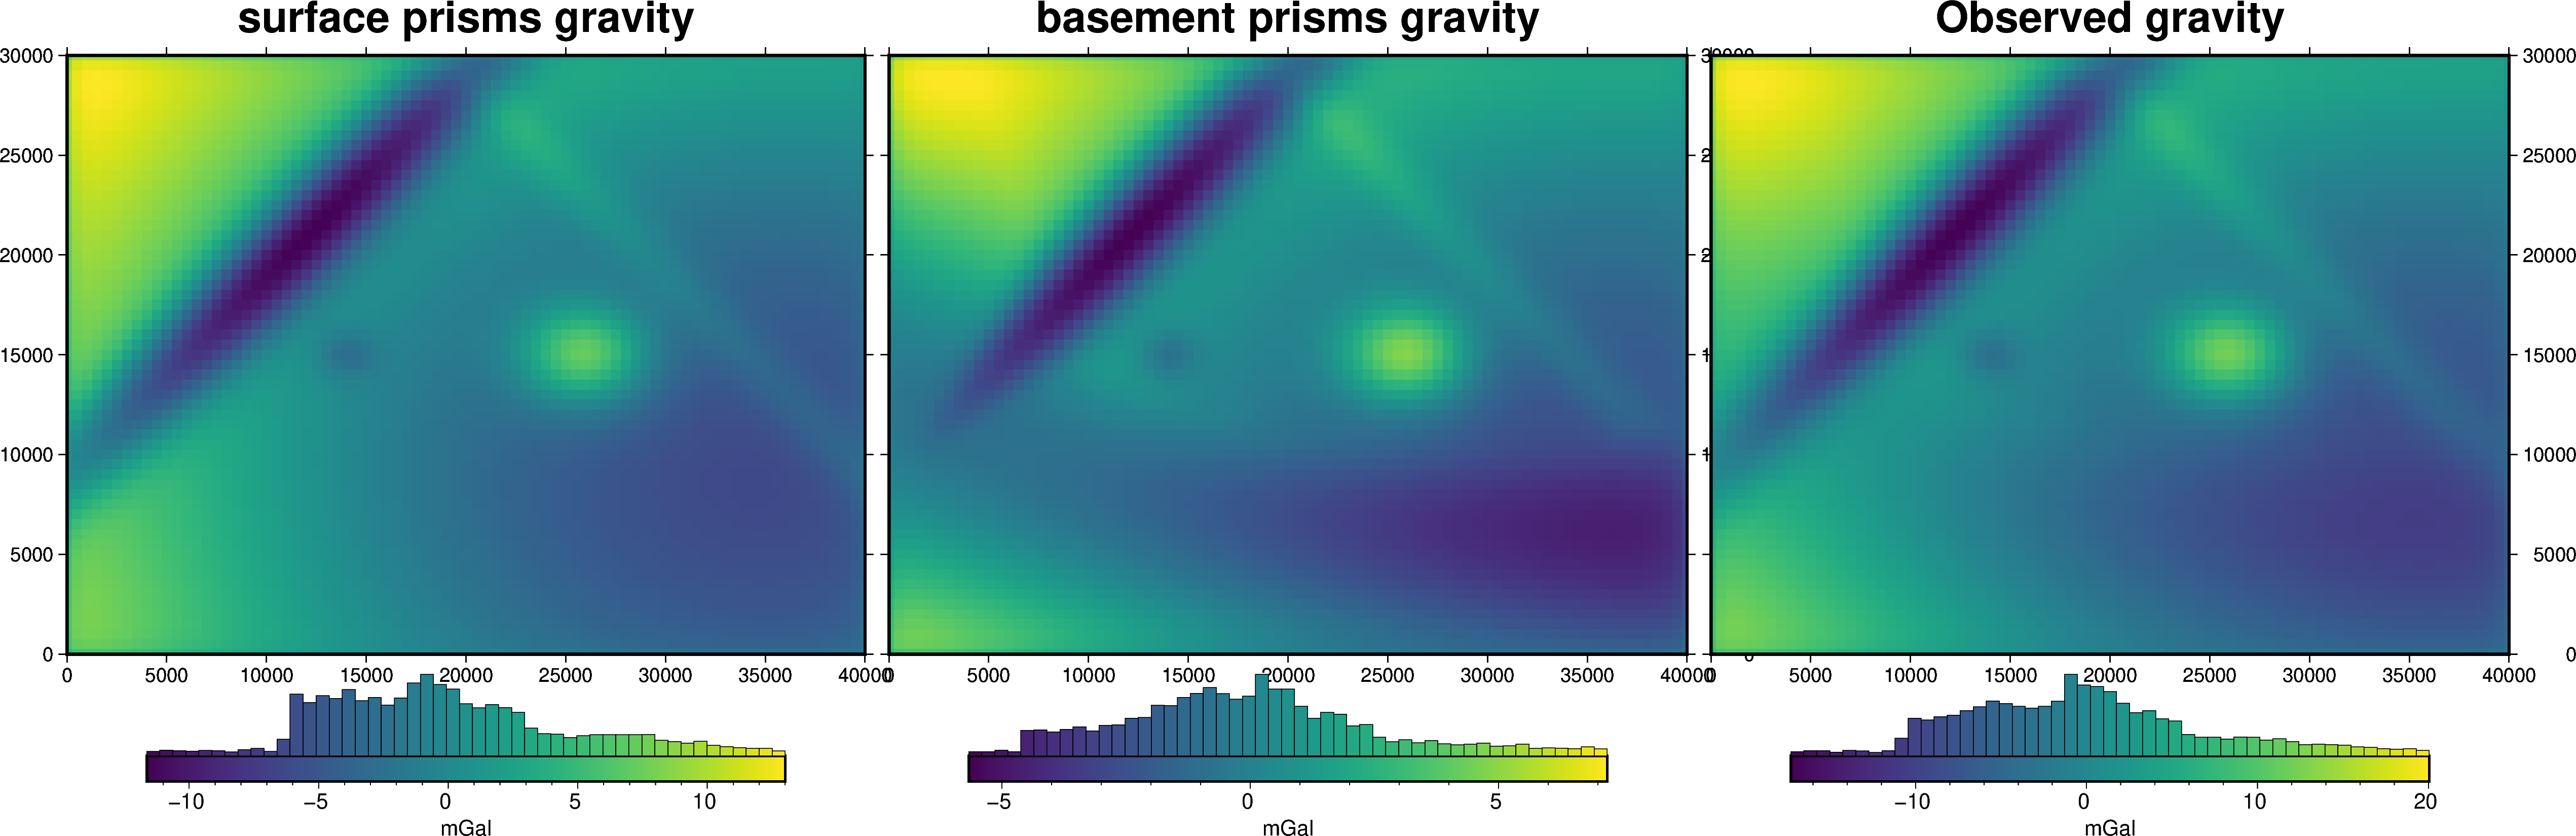

In [8]:
fig = ptk.plot_grid(
    grav_data.surface_grav,
    fig_height=10,
    title="surface prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    grav_data.basement_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="basement prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    grav_data.observed_gravity,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Gravity anomaly
The input gravity anomaly should be corrected for topographic mass (i.e. a Bouguer anomaly). We will forward model the gravity effect of topography and remove it to get the Bouguer anomaly. We already calculated this to create the observed gravity, so we will just subtract it.

In [9]:
grav_data["gravity_anomaly"] = grav_data.observed_gravity - grav_data.surface_grav

## Create starting model
Create a starting model from the interpolation of the 10 constraint points. Also use each grid cell of outcropping basement as an additional constraint point so the starting model equals the basement where it outcrops.

During interpolation, use `upper_confining_layer` and `lower_confining_layer` to make the starting model doesn't ever go above the surface, or below a flat layer at 100 m elevation. 

In [10]:
# make all points where basement outcrops as constraint points
constraint_points = outcropping_basement.to_dataframe().reset_index().dropna()
constraint_points

,northing,easting,upward
4,0.0,2000.0,617.558404
5,0.0,2500.0,612.739407
6,0.0,3000.0,607.952814
7,0.0,3500.0,603.200063
8,0.0,4000.0,598.482591
...,...,...,...
4936,30000.0,38000.0,540.007207
4937,30000.0,38500.0,540.369652
4938,30000.0,39000.0,540.812371
4939,30000.0,39500.0,541.335200


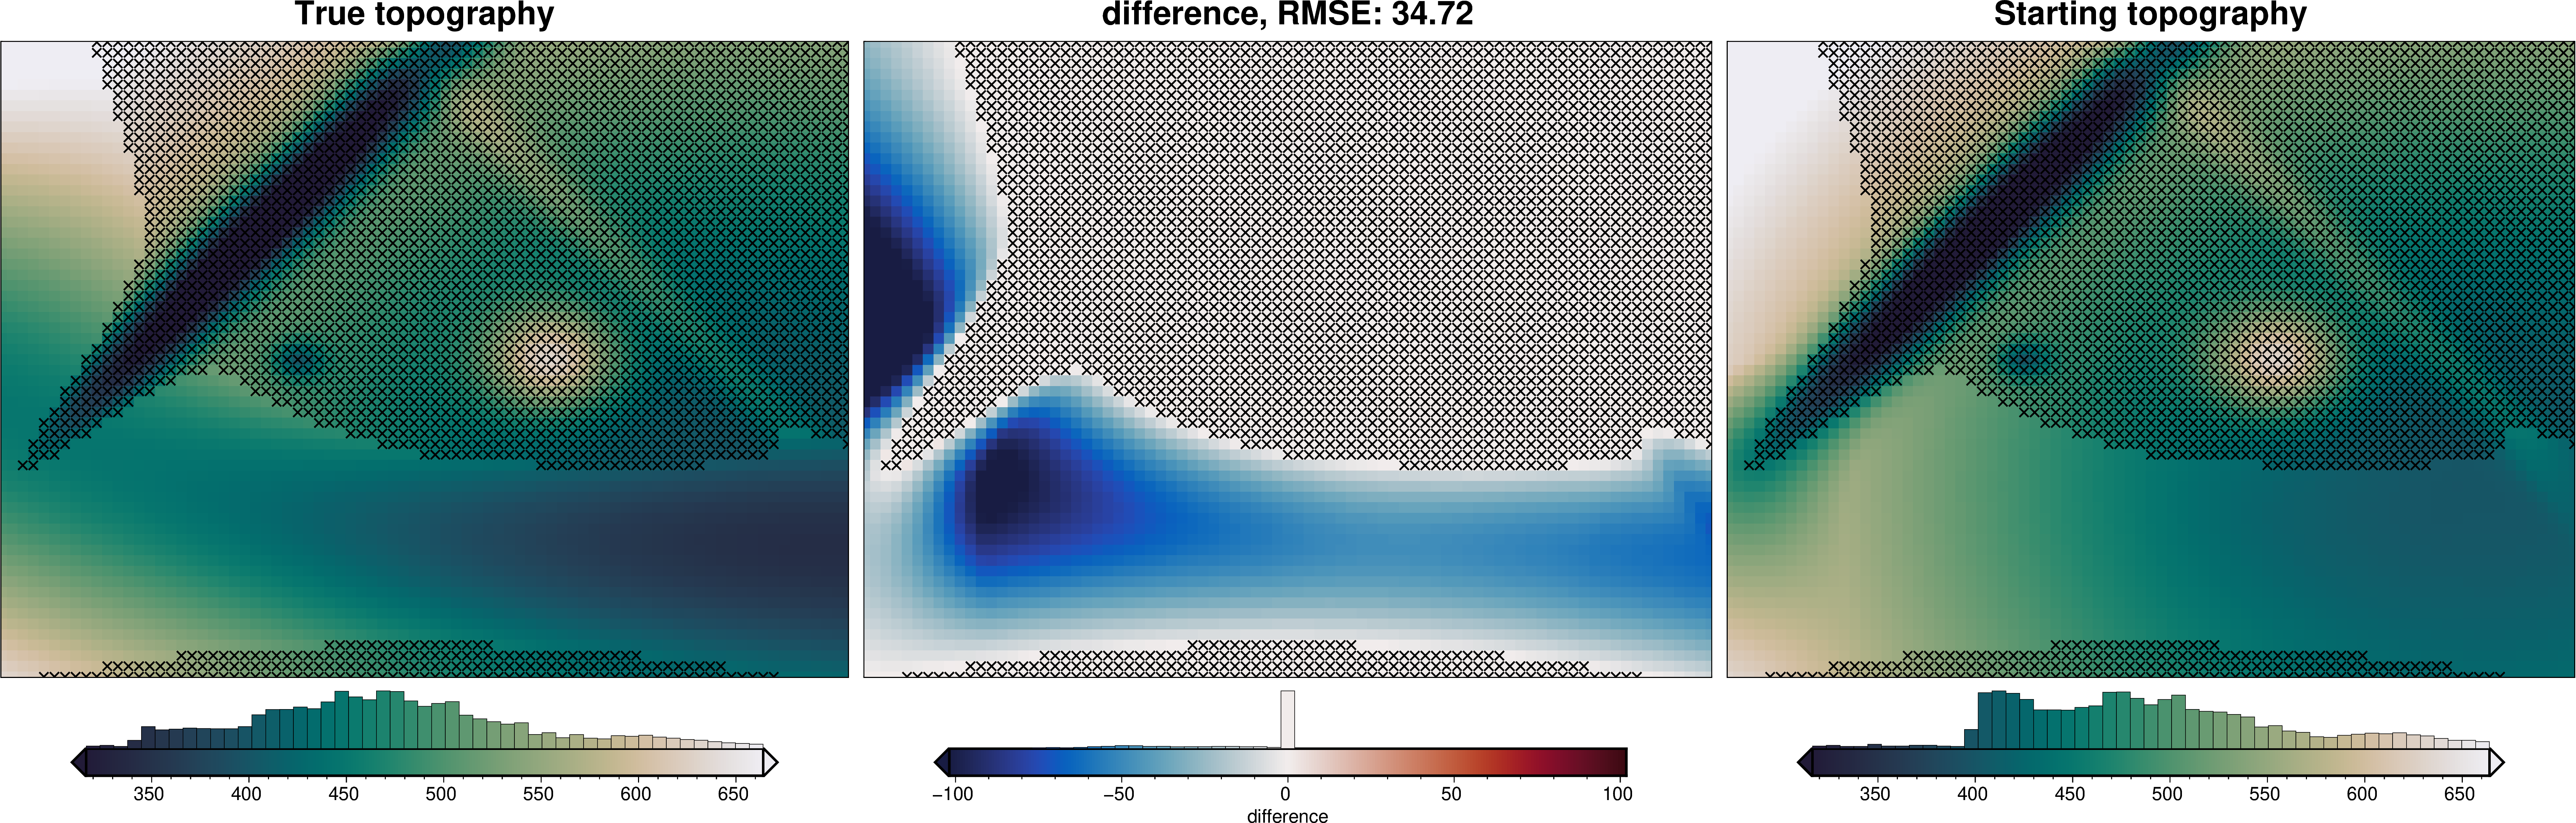

In [11]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=basement_model.region,
    spacing=basement_model.spacing,
    constraints_df=constraint_points,
    dampings=None,
    upper_confining_layer=true_surface_topography,
    lower_confining_layer=xr.full_like(true_surface_topography, 100),
)

starting_topography = invert4geom.create_topography(**starting_topography_kwargs)

_ = ptk.grid_compare(
    true_basement_topography,
    starting_topography.upward,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

Add a `mask` variable to the starting topography. Grid cells with a mask of NaN denote where basement depth is known, and these grid cells are excluded from the inversion and thus not altered. Additionally, since these prisms are excluded, the inversion will be faster due to fewer forward calculations, and a smaller Jacobian matrix.

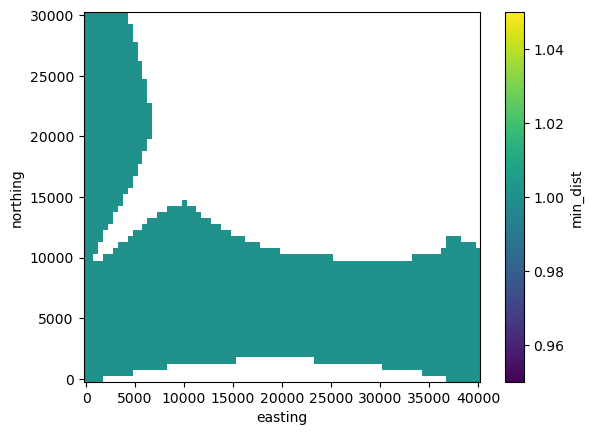

In [12]:
# distance to nearest constraint
min_dist = invert4geom.normalized_mindist(
    constraint_points,
    starting_topography.upward,
)
mask = xr.where(min_dist < 500, np.nan, 1)
mask.plot()

In [13]:
ds = starting_topography

# add mask to dataset
ds["mask"] = mask

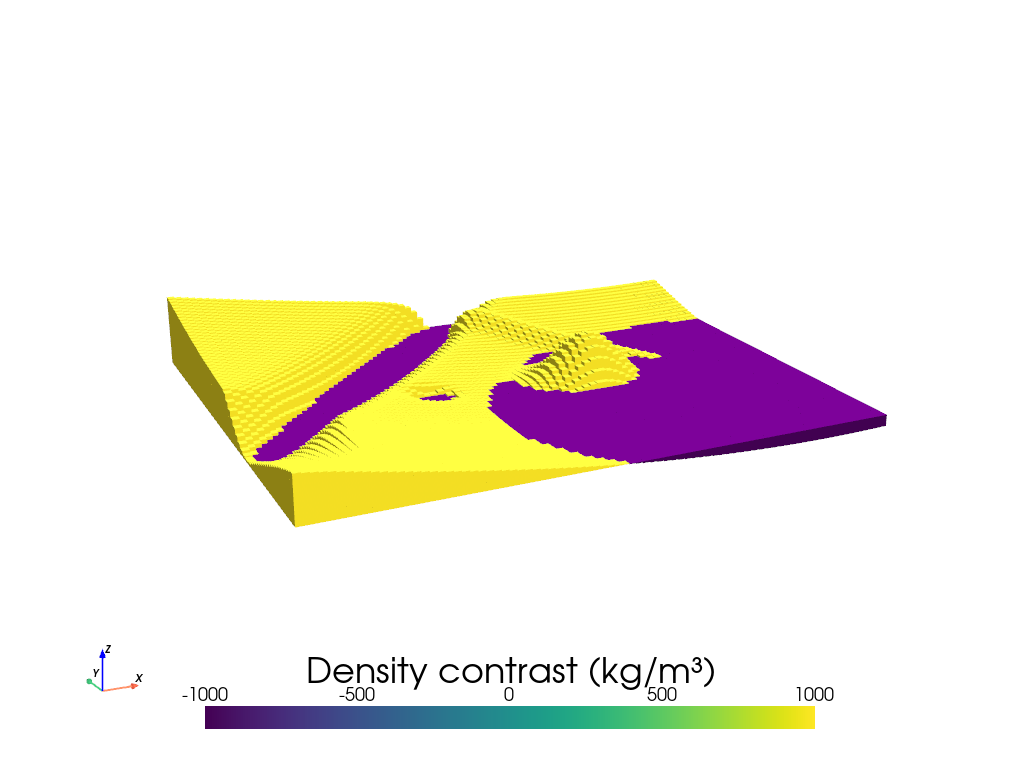

In [14]:
model = invert4geom.create_model(
    zref=true_basement_topography.to_numpy().mean(),
    density_contrast=basement_density_contrast,
    topography=ds,
    upper_confining_layer=true_surface_topography,
    # lower_confining_layer=xr.full_like(true_surface_topography, 100),
)
model.inv.plot_model(
    color_by="density",
    zscale=20,
)

## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [15]:
grav_data.inv.forward_gravity(model, progressbar=True)

grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data

  0%|                                          | 0/4941 [00:00<?, ?it/s]

<xarray.Dataset> Size: 515kB
Dimensions:                   (northing: 61, easting: 81)
Coordinates:
  * easting                   (easting) float64 648B 0.0 500.0 ... 4e+04
  * northing                  (northing) float64 488B 0.0 500.0 ... 3e+04
Data variables: (12/13)
    upward                    (northing, easting) float64 40kB 1.001e+03 ... ...
    surface_grav              (northing, easting) float64 40kB 4.695 ... 1.389
    basement_grav             (northing, easting) float64 40kB 2.747 ... 1.131
    observed_gravity          (northing, easting) float64 40kB 7.443 ... 2.519
    gravity_anomaly           (northing, easting) float64 40kB 2.747 ... 1.131
    forward_gravity           (northing, easting) float64 40kB 2.808 ... 1.133
    ...                        ...
    reg                       (northing, easting) float64 40kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 40kB -0.0612 ... -0...
    starting_forward_gravity  (northing, easting) float64 40kB 2.808 ... 1.133
    starting_misfit           (northing, easting) float64 40kB -0.0612 ... -0...
    starting_reg              (northing, easting) float64 40kB 0.0 0.0 ... 0.0
    starting_res              (northing, easting) float64 40kB -0.0612 ... -0...
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       500.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

makecpt [ERROR]: Option T: min >= max


supplied min value is greater or equal to max value


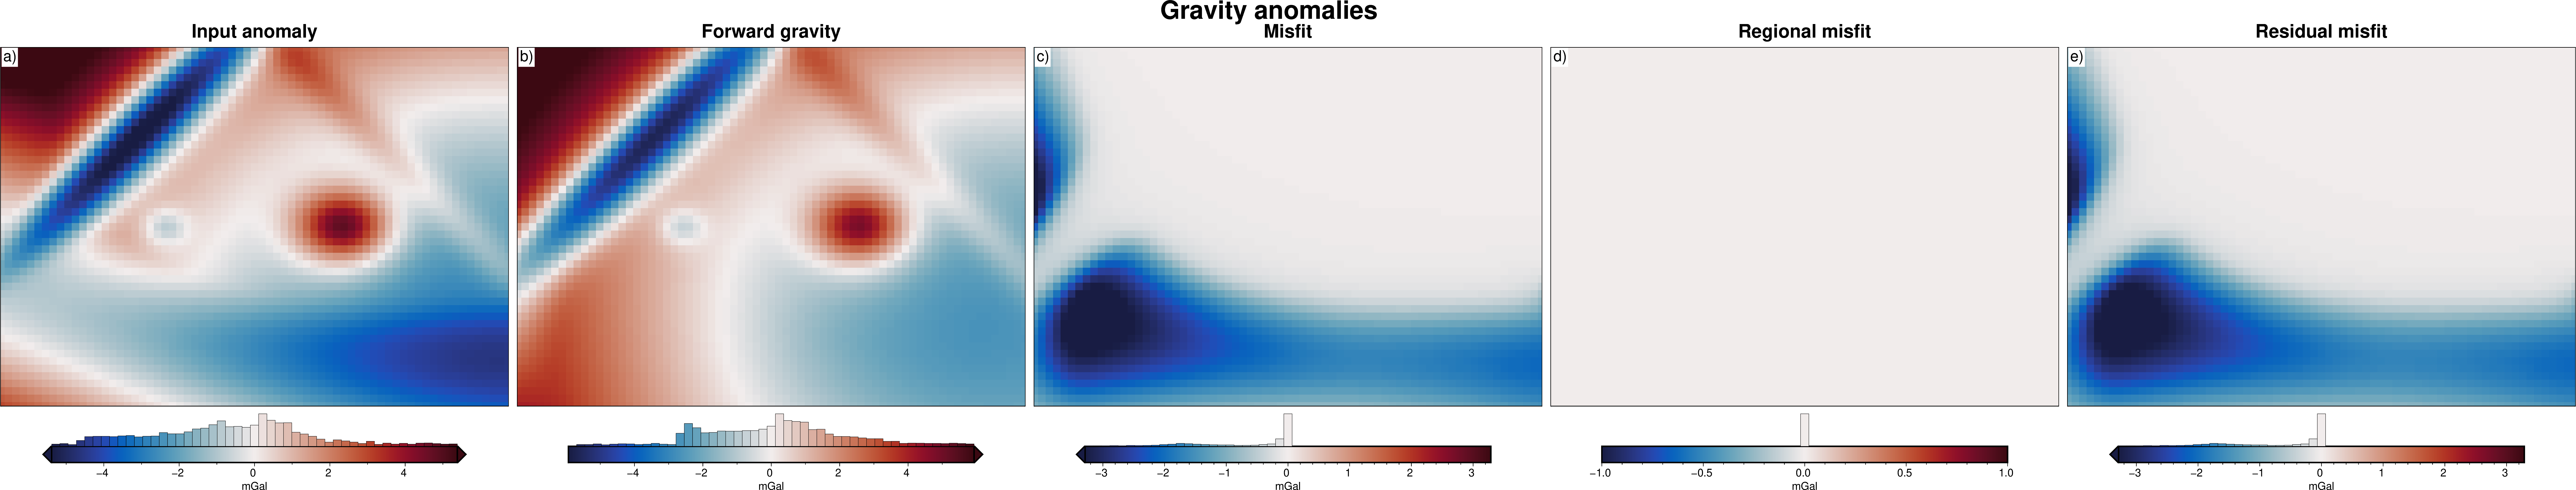

In [16]:
grav_data.inv.plot_anomalies()

## Inversion

In [17]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.01,
    # set stopping criteria
    max_iterations=20,
    l2_norm_tolerance=0.03,
    delta_l2_norm_tolerance=1.1,
)

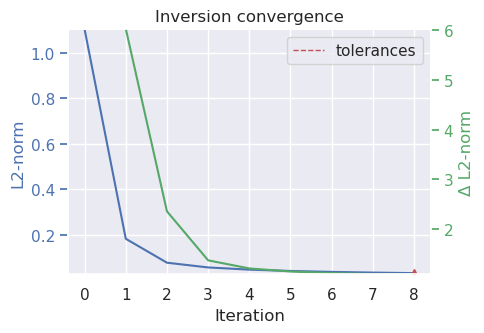

In [18]:
inv.invert(
    plot_dynamic_convergence=True,
    results_fname="tmp/constraining_the_inversion",
)

In [19]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,1.217460,1.103386,inf,NaN
1,1.0,0.033469,0.182944,6.031264,1.438352
2,2.0,0.006045,0.077747,2.353073,1.105911
3,3.0,0.003238,0.056902,1.366331,1.124168
4,4.0,0.002237,0.047295,1.203141,1.146955
5,5.0,0.001716,0.041427,1.141637,1.086785
6,6.0,0.001395,0.037353,1.109065,1.103498
7,7.0,0.001177,0.034307,1.088795,1.092391
8,8.0,0.001019,0.031914,1.074967,1.132289


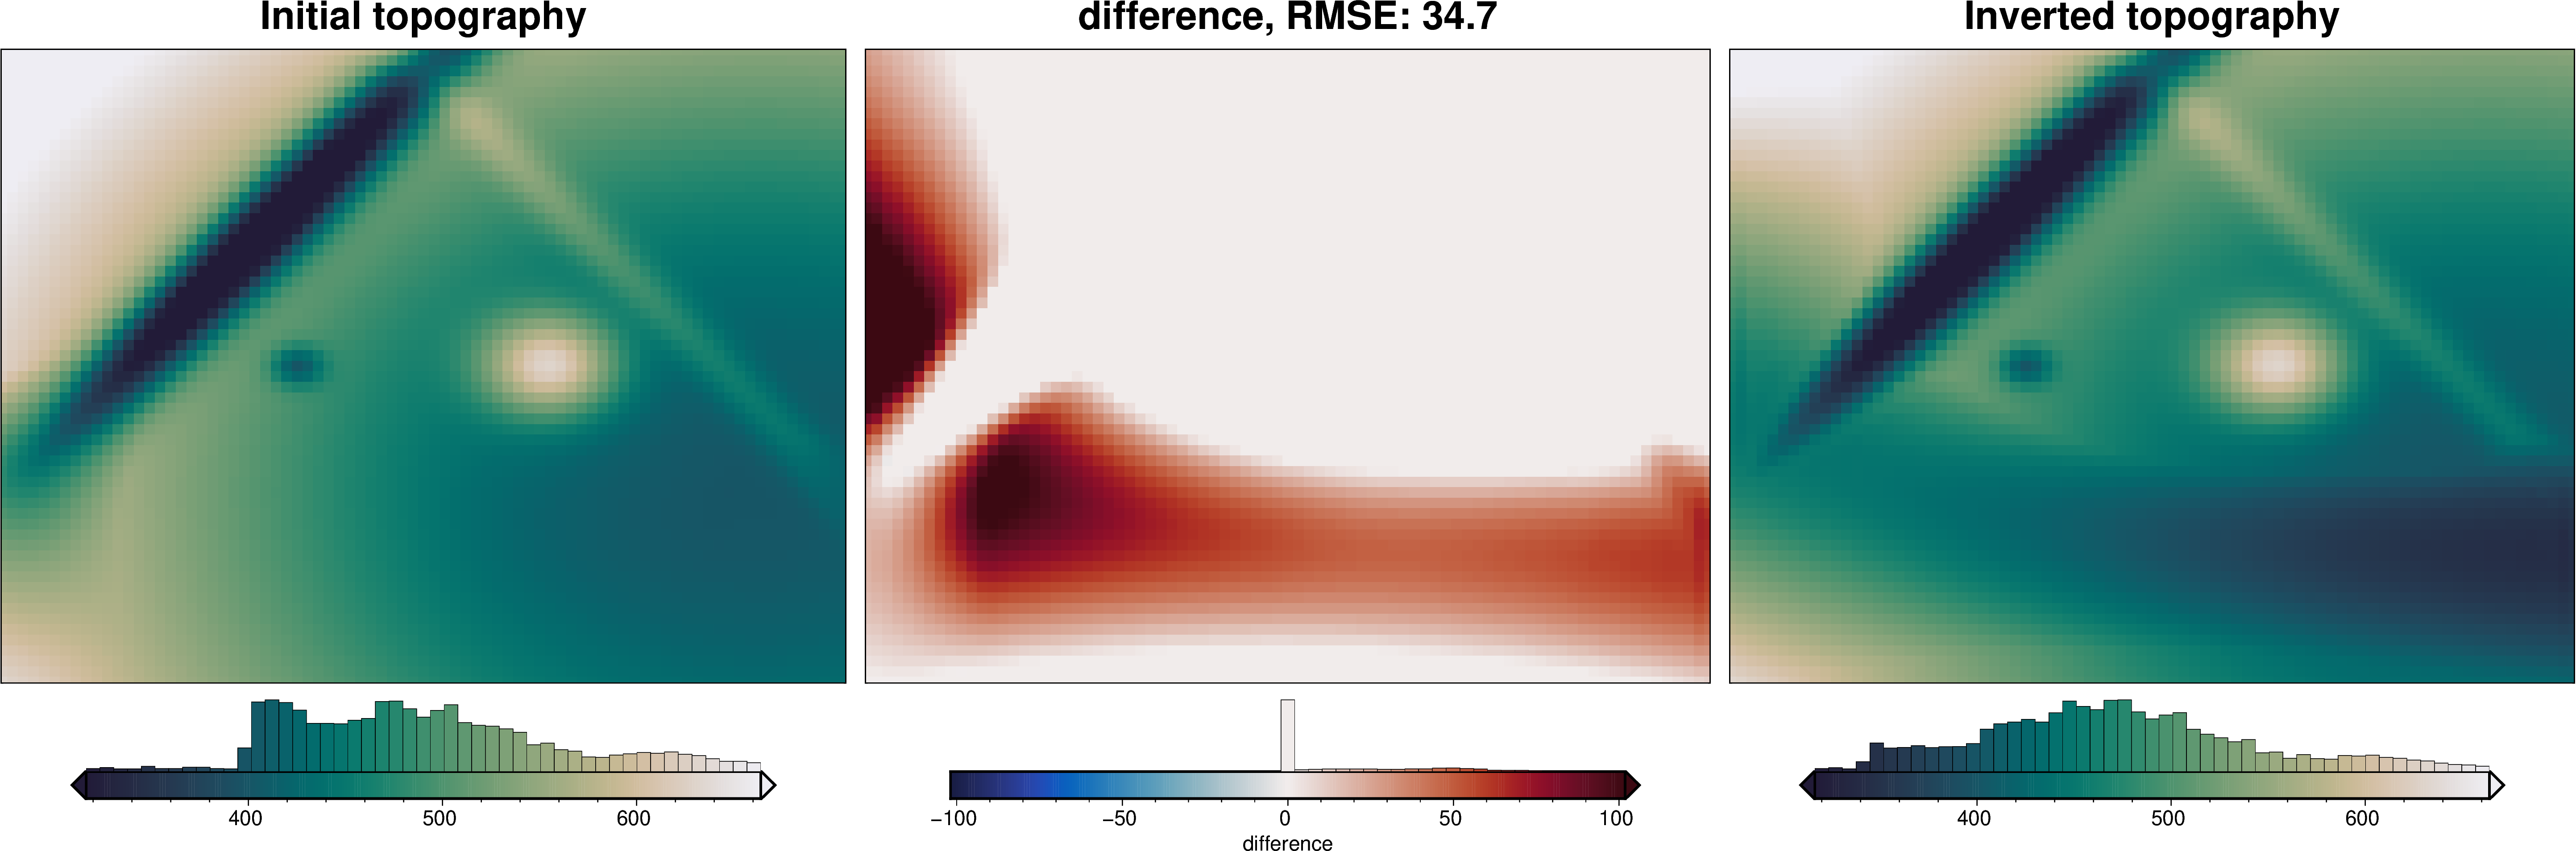

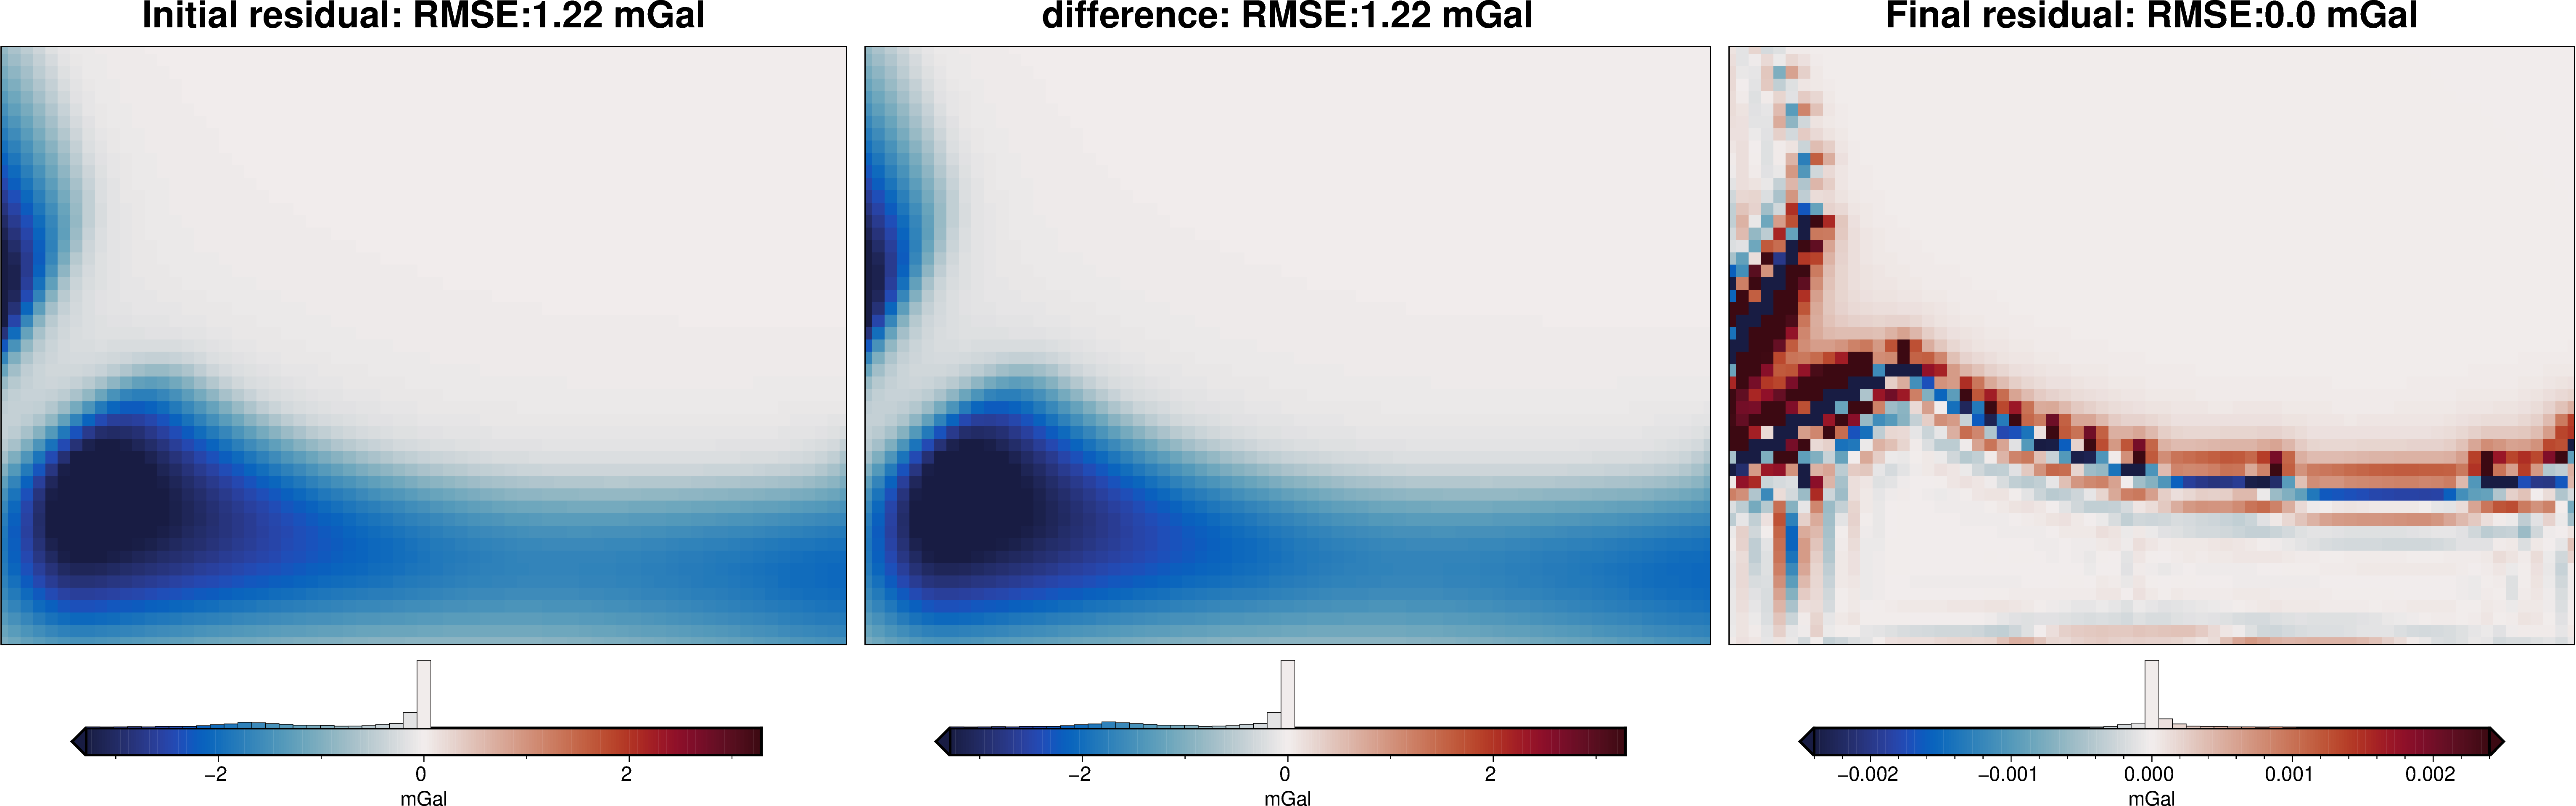

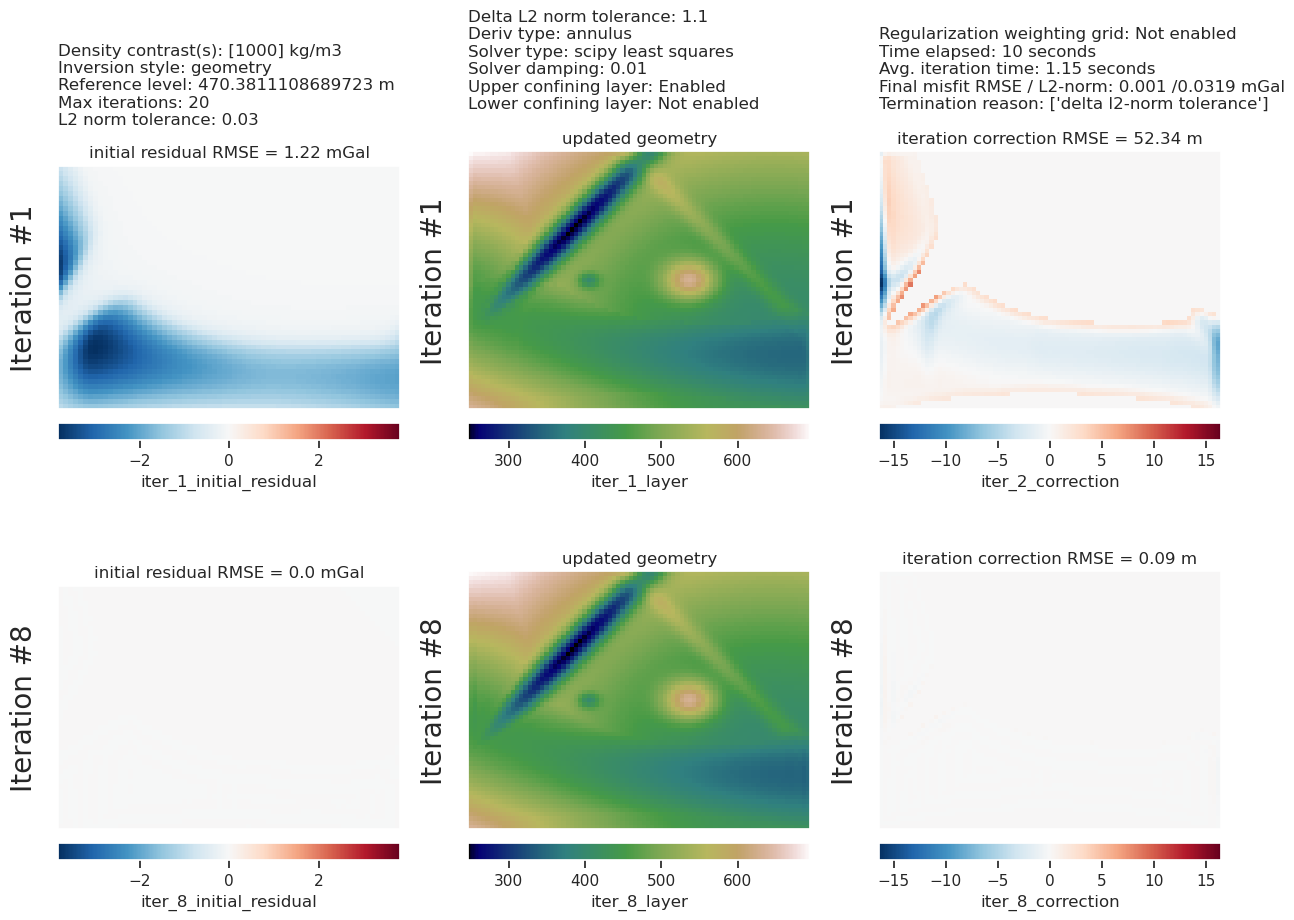

In [20]:
inv.plot_inversion_results(
    iters_to_plot=2,
)

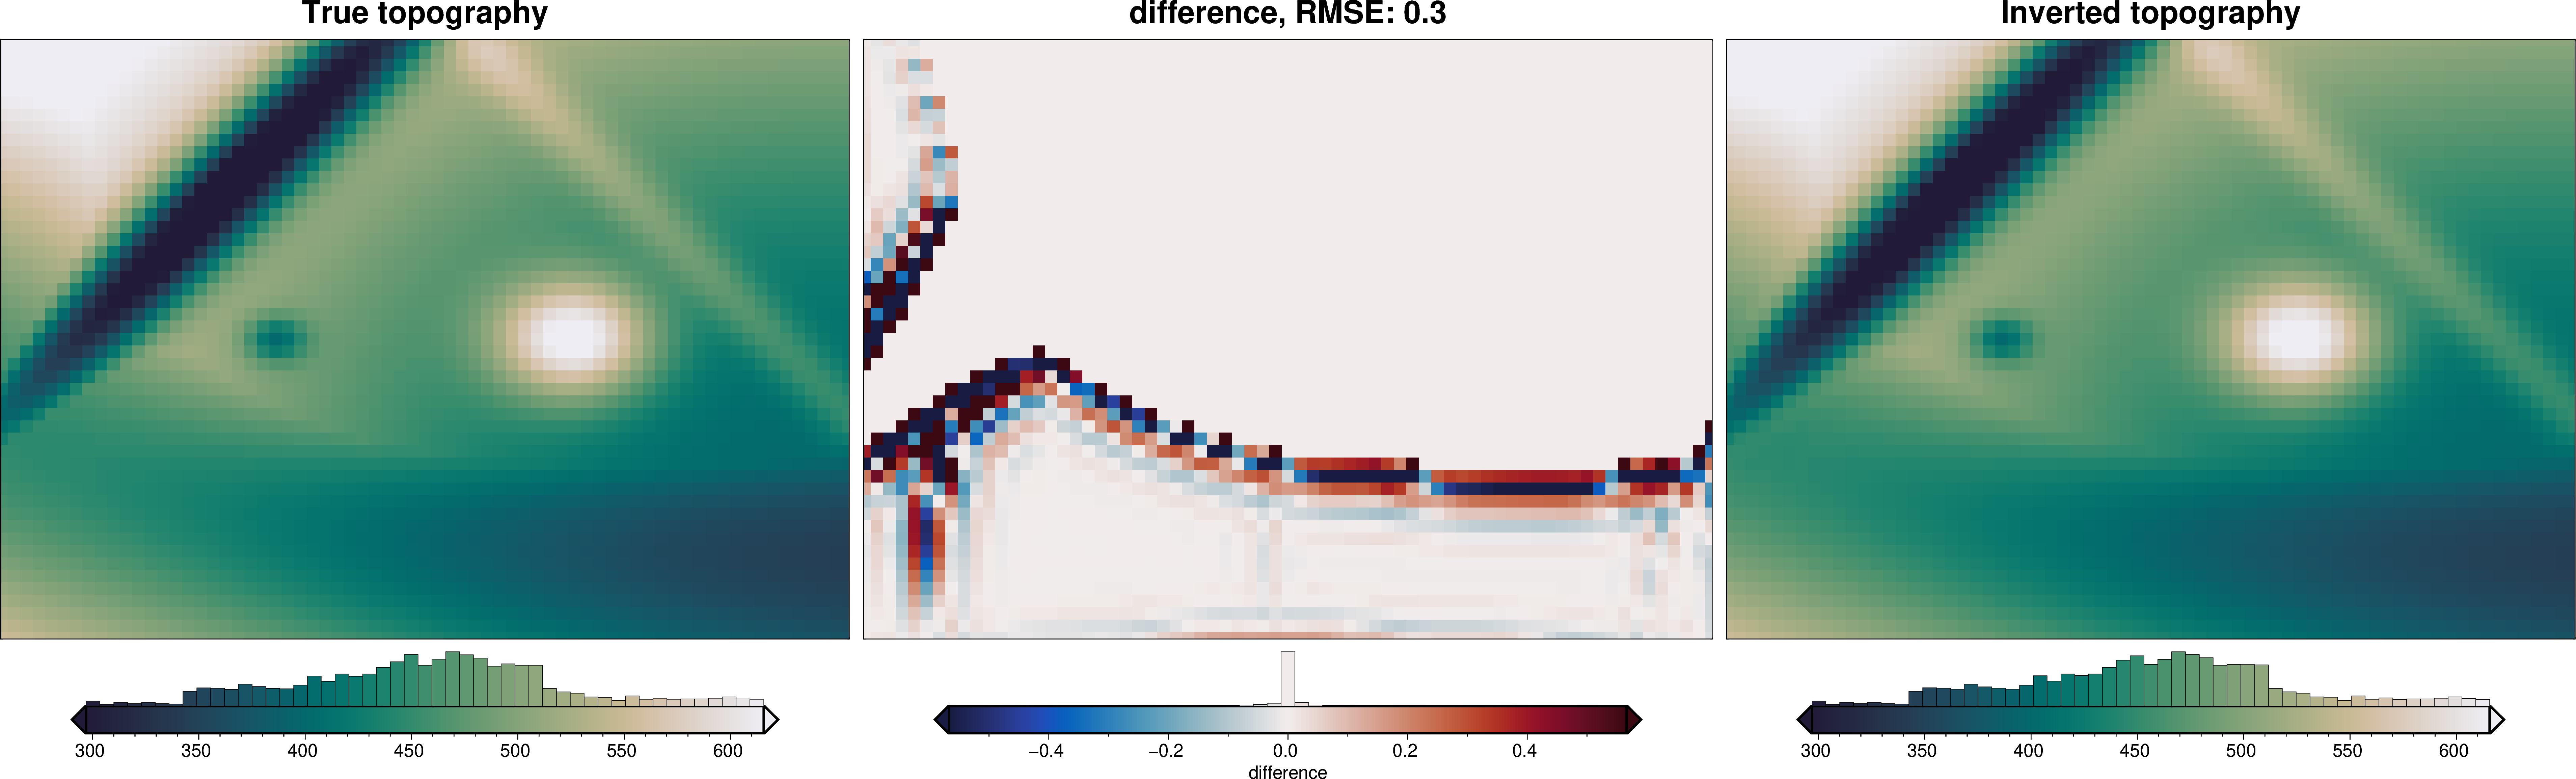

In [21]:
_ = ptk.grid_compare(
    true_basement_topography,
    inv.model.topography,
    region=grav_data.inner_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
)

In [22]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse_without_weighting = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
max_error_without_weighting = vd.maxabs(
    constraint_points.upward - constraint_points.inverted_topography
)

print(f"RMSE at constraints: {round(rmse_without_weighting, 1)} m")
print(f"max error at constraints: {round(max_error_without_weighting, 1)} m")

RMSE at constraints: 0.0 m
max error at constraints: 0.0 m
